# Software Defect Detection

> Lazaros Panitsidis & Konstantinos Kravaritis<br />
> International Hellenic University <br />
> MSc Data Science <br />
> Machine Learning Concepts and Principles <br />
> lpanitsidis@ihu.edu.gr & kkravaritis@ihu.edu.gr

## Contents
1. [Python Libraries](#0)
1. [Functions](#1)
1. [Data Preprocessing](#2)
1. [ML Models](#3)
1. [Results](#4)

<a id='0'></a>
## Python Libraries

In [1]:
## Install Python libraries
# %pip install -U numpy
# %pip install -U pandas
# %pip install -U seaborn
# %pip install -U matplotlib
# %pip install -U scikit-learn
# %pip install -U imbalanced-learn

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import statistics as stats # https://docs.python.org/3/library/statistics.html#statistics.fmean
#import scipy.stats as spstats
import matplotlib.pyplot as plt

### Validation & Normalization methods ###
from sklearn.model_selection import cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

### ML models ###
from sklearn.linear_model import LogisticRegression, SGDClassifier # C1 loss: log_loss => LogisticRegression with SGD
from sklearn.linear_model import Perceptron # C2
from sklearn.svm import SVC # C3
from sklearn.svm import LinearSVC # C4
from sklearn.tree import DecisionTreeClassifier # C5
from sklearn.ensemble import RandomForestClassifier # C6
from sklearn.neural_network import MLPClassifier # C7

### Metrics ###
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from imblearn.metrics import geometric_mean_score # https://imbalanced-learn.org/stable/references/generated/imblearn.metrics.geometric_mean_score.html
import time
import timeit # https://stackoverflow.com/questions/17579357/time-time-vs-timeit-timeit

### Pipeline ###
from sklearn.pipeline import make_pipeline , Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

### Custom Modules ###
# from functions.data_types import optimize_dtypes
# from functions.dataframe_actions import df_info, df_clean
# from functions.ml_training import train_classifiers, train_classifiers_tuned

### Other configurations ###
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
# #import warnings library
# import warnings
# # ignore all warnings
# warnings.filterwarnings('ignore')

/home/lazaros/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


<a id='1'></a>
## Functions

#### Information about the dataframes

In [3]:
def df_info(dataframes, dataframe_names):
    """
    Finds useful information about all dataframes given in the function.

    Usage: pass a list of dataframes and their names into the function
    dataframes = [df1, df2, ...]
    dataframe_names = ["df1", "df2", ...]

    Output: print's information about schema, missing values, duplicate values and value counts for target column.
    """

    for df, df_name in zip(dataframes, dataframe_names):
        # Check if the dataframe has at least one column
        if not df.empty:
            print("----- information for ", df_name, " -----")
            print(df_name, " : ", df.shape, "(rows, columns)")
            print(df_name, " : ", df.isna().sum().sum(), "missing values")
            print(df_name, " : ", df.duplicated().sum(), "duplicate values")

            # Identify and count values of the last column
            last_column = df.columns[-1]
            value_counts = df[last_column].value_counts()

            print(df_name, " : Value counts for ", last_column)
            print(value_counts)
        else:
            print(df_name, ': The dataframe is empty.')

#### Clean dataframe from non-numeric values

In [4]:
def df_clean(df):
    """
    Eliminate invalid data from the dataframe.

    This function replaces non-numeric values in the specified columns
    with NaN and removes rows containing NaN values.

    Parameters:
    - df: pandas DataFrame

    Returns:
    - Cleaned DataFrame
    """
    df_columns = df.columns.to_list()

    # https://stackoverflow.com/questions/21771133/finding-non-numeric-rows-in-dataframe-in-pandas
    
    num_df = (
        df.drop(df_columns, axis=1)
          .join(df[df_columns].apply(pd.to_numeric, errors='coerce'))
    )

    num_df = num_df[num_df[df_columns].notnull().all(axis=1)]

    return num_df

#### Optimize data types for more efficient computation

In [5]:
def optimize_dtypes(df):
  """
  Finds the optimal data type for each variable in a DataFrame.
  
  The 'np.iinfo(), np.finfo()' functions are used to obtain the minimum and maximum values 
  for the data types accurately, ensuring better compatibility across different systems.

  Args:
    df: A pandas DataFrame.

  Returns:
    A DataFrame containing the optimal data type for each variable.
  """

  data_types_dict = {}
  for column in df.columns:
    # Get the data type of the column.
    column_type = df[column].dtype

    # Determine the optimal data type for the column.
    if column_type in ('int8', 'int16', 'int32' , 'int64', 'uint8', 'uint16' , 'uint32', 'uint64', 
                       'float16', 'float32', 'float64'):
      # Calculate the minimum and maximum values of the column.
      min_value = df[column].min()
      max_value = df[column].max()

      # Determine the optimal data type for the column based on the minimum and maximum values.
      if isinstance(min_value, (int, np.integer)):
        if min_value < 0:
          # The column contains negative values, so we need to use a signed data type.
          if max_value < np.iinfo(np.int8).max:
            data_types_dict[column] = np.int8
          elif max_value < np.iinfo(np.int16).max:
            data_types_dict[column] = np.int16
          elif max_value < np.iinfo(np.int32).max:
            data_types_dict[column] = np.int32
          else:
            data_types_dict[column] = np.int64
        else:
          # The column contains only non-negative values, so we can use an unsigned data type.
          if max_value < np.iinfo(np.uint8).max:
            data_types_dict[column] = np.uint8
          elif max_value < np.iinfo(np.uint16).max:
            data_types_dict[column] = np.uint16
          elif max_value < np.iinfo(np.uint32).max:
            data_types_dict[column] = np.uint32
          else:
            data_types_dict[column] = np.uint64
      elif isinstance(min_value, float):
        if max_value < np.finfo(np.float16).max:
          data_types_dict[column] = np.float16
        elif max_value < np.finfo(np.float32).max:
          data_types_dict[column] = np.float32
        else:
          data_types_dict[column] = np.float64
    else:
      pass

  return df.astype(data_types_dict)

#### Training multiple classifiers

In [6]:
def train_classifiers(classifiers, x, y, cv, scoring, scaler=None):
    results = {}

    for classifier in classifiers:
        if scaler is not None:
            # Create a pipeline with the specified scaler and the current classifier
            pipe = Pipeline([('scaler', scaler), ('classifier', classifier)])
        else:
            # Create a pipeline with only the classifier (no scaling)
            pipe = Pipeline([('classifier', classifier)])


        # Use cross_validate to obtain scores
        scores = cross_validate(pipe, x, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

        # Input the scores in a dictionary
        results[classifier.__class__.__name__] = {
            'Accuracy': stats.fmean(scores['test_Accuracy']),
            'F1-score': stats.fmean(scores['test_F1-score']),
            'G-Mean score': stats.fmean(scores['test_G-Mean score']),
            'Fit time': sum(scores['fit_time'])
        }

    return results

#### Plot the metrics

In [7]:
def plot_metrics(df):
    # set the plot style
    sns.set(style="whitegrid", palette="muted", font_scale=1)

    # Plot Accuracy
    plt.figure(figsize=(20, 4))
    acc = sns.barplot(data=df, x='Classifier', y='Accuracy', hue='Normalization method')
    acc.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
    acc.set_ylim(0, 1)
    for container in acc.containers:
        acc.bar_label(container)
    plt.show()

    # Plot F1-score
    plt.figure(figsize=(20, 4))
    f1 = sns.barplot(data=df, x='Classifier', y='F1-score', hue='Normalization method')
    f1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
    f1.set_ylim(0, 1)
    for container in f1.containers:
        f1.bar_label(container)
    plt.show()

    # Plot G-Mean score
    plt.figure(figsize=(20, 4))
    gmean = sns.barplot(data=df, x='Classifier', y='G-Mean score', hue='Normalization method')
    gmean.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
    gmean.set_ylim(0, 1)
    for container in gmean.containers:
        gmean.bar_label(container)
    plt.show()

    # Plot Fit time
    plt.figure(figsize=(20, 4))
    fit_time = sns.barplot(data=df, x='Classifier', y='Fit time', hue='Normalization method')
    fit_time.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
    fit_time.set_ylim(0, max(df['Fit time']) + 1)
    for container in fit_time.containers:
        fit_time.bar_label(container)
    plt.show()

<a id='2'></a>
## Data Preprocessing

### read the .csv files and make dataframes

In [8]:
# to read .csv files from another directory
data_location = "" # "/<path>"

jm1 = pd.read_csv(data_location + "jm1.csv")
mc1 = pd.read_csv(data_location + "mc1.csv")
pc3 = pd.read_csv(data_location + "pc3.csv")

### clean the dataframes from non-numeric data

In [9]:
# drop all rows that cointain non numeric valeus
jm1 = df_clean(jm1)
mc1 = df_clean(mc1)
pc3 = df_clean(pc3)

### extract useful information about the dataframes

In [10]:
dataframes = [jm1, mc1, pc3]
dataframe_names = ["jm1", "mc1", "pc3"]
df_info(dataframes, dataframe_names)

----- information for  jm1  -----
jm1  :  (10880, 22) (rows, columns)
jm1  :  0 missing values
jm1  :  1973 duplicate values
jm1  : Value counts for  defects
defects
False    8777
True     2103
Name: count, dtype: int64
----- information for  mc1  -----
mc1  :  (9466, 39) (rows, columns)
mc1  :  0 missing values
mc1  :  7450 duplicate values
mc1  : Value counts for  c
c
False    9398
True       68
Name: count, dtype: int64
----- information for  pc3  -----
pc3  :  (1563, 38) (rows, columns)
pc3  :  0 missing values
pc3  :  124 duplicate values
pc3  : Value counts for  c
c
False    1403
True      160
Name: count, dtype: int64


#### Label Encoding

* Use map instead of LabelEncoder() to ensure that False is 0 and True is 1 in all dataframes.
* With LabelEncoder() it depends on the order that the labels appear in the dataframe.

In [11]:
# class_le = LabelEncoder()
# jm1['defects'] = class_le.fit_transform(jm1['defects'].values)
# print("Classes of Label Encoder:", class_le.classes_)

In [12]:
# Map the "size" ordinal feature to an integer value
map_lexicon = {False: 0, True: 1}
jm1['defects'] = jm1['defects'].map(map_lexicon)
mc1['c'] = mc1['c'].map(map_lexicon)
pc3['c'] = pc3['c'].map(map_lexicon)

#### find optimal data types for faster computation

In [13]:
jm1 = optimize_dtypes(jm1)
mc1 = optimize_dtypes(mc1)
pc3 = optimize_dtypes(pc3)

In [14]:
print("---------- Optimal Data Types ----------")
print(jm1.dtypes)
print("---------- Optimal Data Types ----------")
print(mc1.dtypes)
print("---------- Optimal Data Types ----------")
print(pc3.dtypes)

---------- Optimal Data Types ----------
loc                  float16
v(g)                 float16
ev(g)                float16
iv(g)                float16
n                    float16
v                    float32
l                    float16
d                    float16
i                    float16
e                    float32
b                    float16
t                    float32
lOCode                uint16
lOComment             uint16
lOBlank               uint16
locCodeAndComment      uint8
uniq_Op              float16
uniq_Opnd            float16
total_Op             float16
total_Opnd           float16
branchCount          float16
defects                uint8
dtype: object
---------- Optimal Data Types ----------
LOC_BLANK                            uint8
BRANCH_COUNT                        uint16
CALL_PAIRS                           uint8
LOC_CODE_AND_COMMENT                 uint8
LOC_COMMENTS                         uint8
CONDITION_COUNT                     uint16
CYCLOMAT

#### Define Feature variables (inputs or predictors) and Target variables

In [15]:
jm1_y = jm1.defects
jm1_x = jm1.drop('defects',axis = 1 )

mc1_y = mc1.c
mc1_x = mc1.drop('c',axis = 1 )

pc3_y = pc3.c
pc3_x = pc3.drop('c',axis = 1 )

<a id='3'></a>
## ML Models

#### define the classifiers

* All classifiers should have the same hyperparameters in order for the comparison to be fair.

In [92]:
# ## very bad scores in jm1 and in general for perceptron and svc
# np.random.MT19937(seed=13)

# lr = LogisticRegression(solver= 'saga', penalty='elasticnet',l1_ratio=0.5, dual=False, max_iter=1000, n_jobs=-1) # 'l2' & 'newton-cholesky'
# perc = Perceptron(penalty='elasticnet', l1_ratio=0.5, class_weight='balanced', max_iter=1000, n_jobs=-1)
# #linear_svm = SVC(kernel='linear', cache_size=4000) # training doesnt stop
# linear_svm = LinearSVC(penalty='l2',dual=False, class_weight='balanced', max_iter=1000)
# rbf_svm = SVC(kernel='rbf', gamma='scale', cache_size=4000, class_weight='balanced', max_iter=1000)
# tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split= 3, min_samples_leaf=2, class_weight='balanced', ccp_alpha=0.01) # 'gini is faster, 'entrtopy' usually gives slightly better results # https://quantdare.com/decision-trees-gini-vs-entropy/
# rf = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=None, min_samples_split=3, min_samples_leaf=2, class_weight='balanced', ccp_alpha=0.01,n_jobs=-1)
# mlp = MLPClassifier(hidden_layer_sizes=(20,10), solver='adam', learning_rate='adaptive', learning_rate_init=0.01, max_iter=1000)

# classifiers = [lr, perc, linear_svm, rbf_svm, tree, rf, mlp]

In [148]:
# np.random.MT19937(seed=13)

# lr = LogisticRegression(solver= 'newton-cholesky', penalty='l2', max_iter=1000, n_jobs=-1) # 'l2' & 'newton-cholesky'
# perc = Perceptron(penalty='elasticnet', l1_ratio=0.1, class_weight='balanced', max_iter=1000, n_jobs=-1)
# #linear_svm = SVC(kernel='linear', cache_size=4000) # training doesnt stop
# linear_svm = LinearSVC(penalty='l2',dual=False, class_weight='balanced', max_iter=1000)
# rbf_svm = SVC(kernel='rbf', gamma='scale', cache_size=4000, class_weight='balanced', max_iter=1000)
# tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split= 3, min_samples_leaf=2, class_weight='balanced', ccp_alpha=0.01) # 'gini is faster, 'entrtopy' usually gives slightly better results # https://quantdare.com/decision-trees-gini-vs-entropy/
# rf = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=None, min_samples_split=3, min_samples_leaf=2, class_weight='balanced', ccp_alpha=0.01,n_jobs=-1)
# mlp = MLPClassifier(hidden_layer_sizes=(20,10), solver='adam', learning_rate='adaptive', learning_rate_init=0.01, max_iter=1000)

# classifiers = [lr, perc, linear_svm, rbf_svm, tree, rf, mlp]

In [252]:
np.random.MT19937(seed=13)

lr = LogisticRegression()
perc = Perceptron()
#linear_svm = SVC(kernel='linear', cache_size=30000) # training doesnt stop
linear_svm = LinearSVC()
rbf_svm = SVC()
tree = DecisionTreeClassifier()
rf = RandomForestClassifier()
mlp = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', learning_rate='adaptive', learning_rate_init=0.01, max_iter=1000)

classifiers = [lr, perc, linear_svm, rbf_svm, tree, rf, mlp]

#### define the metrics

In [253]:
# Define multiple metrics
scoring = {'Accuracy': make_scorer(accuracy_score),
           'F1-score': make_scorer(f1_score, average='weighted'),
           'G-Mean score': make_scorer(geometric_mean_score, average='weighted')
          }

#### define the normalization methods

In [254]:
min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()

## If we use MinMaxScaler or StandardScaler, the feature names will be lost, so we do it mannually.

# x_scaled = (x - x.min(axis=0)) / (x.max(axis=0)-x.min(axis=0))
# x_scaled = (x - x.mean())/x.std()

#### define Cross Validation's folds method

In [255]:
#rng = np.random.RandomState(13) # random number generator , use it in every random state if shuffle=True for different results.Usefull to test a specific algorithm multiple times within a for loop.
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
#search_cv = StratifiedKFold(n_splits=3, shuffle=False, random_state=None) # for nested cross validation in order tune the hyperparameters automatically

### N1: No Normalization

#### jm1

In [256]:
jm1_nn_results = train_classifiers(classifiers, jm1_x, jm1_y, cv, scoring)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [257]:
# convert to dataframe for easier visualization (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.from_dict.html)
df_jm1_nn_results = pd.DataFrame.from_dict(jm1_nn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_jm1_nn_results['Normalization method'] = 'No normalization'
#df_jm1_nn_results

#### mc1

In [258]:
mc1_nn_results = train_classifiers(classifiers, mc1_x, mc1_y, cv, scoring)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter

In [259]:
# convert to dataframe for easier visualization
df_mc1_nn_results = pd.DataFrame.from_dict(mc1_nn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_mc1_nn_results['Normalization method'] = 'No normalization'
#df_mc1_nn_results

#### pc3

In [260]:
pc3_nn_results = train_classifiers(classifiers, pc3_x, pc3_y, cv, scoring)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [261]:
# convert to dataframe for easier visualization
df_pc3_nn_results = pd.DataFrame.from_dict(pc3_nn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_pc3_nn_results['Normalization method'] = 'No normalization'
#df_pc3_nn_results

### N2: Min-Max Normalization

#### jm1

In [262]:
jm1_mmn_results = train_classifiers(classifiers, jm1_x, jm1_y, cv, scoring, min_max_scaler)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3

In [263]:
# convert to dataframe for easier visualization
df_jm1_mmn_results = pd.DataFrame.from_dict(jm1_mmn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_jm1_mmn_results['Normalization method'] = 'Min-Max normalization'
#df_jm1_mmn_results

#### mc1

In [264]:
mc1_mmn_results = train_classifiers(classifiers, mc1_x, mc1_y, cv, scoring, min_max_scaler)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3

In [265]:
# convert to dataframe for easier visualization
df_mc1_mmn_results = pd.DataFrame.from_dict(mc1_mmn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_mc1_mmn_results['Normalization method'] = 'Min-Max normalization'
#df_mc1_mmn_results

#### pc3

In [266]:
pc3_mmn_results = train_classifiers(classifiers, pc3_x, pc3_y, cv, scoring, min_max_scaler)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3

In [267]:
# convert to dataframe for easier visualization
df_pc3_mmn_results = pd.DataFrame.from_dict(pc3_mmn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_pc3_mmn_results['Normalization method'] = 'Min-Max normalization'
#df_pc3_mmn_results

### N3: Feature Standardization

#### jm1

In [268]:
jm1_fs_results = train_classifiers(classifiers, jm1_x, jm1_y, cv, scoring, std_scaler)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [269]:
# convert to dataframe for easier visualization
df_jm1_fs_results = pd.DataFrame.from_dict(jm1_fs_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_jm1_fs_results['Normalization method'] = 'Standardization'
#df_jm1_fs_results

#### mc1

In [270]:
mc1_fs_results = train_classifiers(classifiers, mc1_x, mc1_y, cv, scoring, std_scaler)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3

In [271]:
# convert to dataframe for easier visualization
df_mc1_fs_results = pd.DataFrame.from_dict(mc1_fs_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_mc1_fs_results['Normalization method'] = 'Standardization'
#df_mc1_fs_results

#### pc3

In [272]:
pc3_fs_results = train_classifiers(classifiers, pc3_x, pc3_y, cv, scoring, std_scaler)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lazaros/.local/lib/python3

In [273]:
# convert to dataframe for easier visualization
df_pc3_fs_results = pd.DataFrame.from_dict(pc3_fs_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_pc3_fs_results['Normalization method'] = 'Standardization'
#df_pc3_fs_results

In [274]:
# ## example without using train_classifiers function

# lr_fs_pipe = Pipeline([('std_scaler', StandardScaler()), ('lr', LogisticRegression())])

# jm1_lr_fs_scores = cross_validate(lr_fs_pipe, jm1_x, jm1_y,
#                         cv=cv, scoring=scoring,
#                         n_jobs=None, return_train_score=False)

# jm1_lr_fs_accuracy = stats.fmean(jm1_lr_fs_scores['test_Accuracy'])
# jm1_lr_fs_f1 = stats.fmean(jm1_lr_fs_scores['test_F1-score'])
# jm1_lr_fs_g_mean = stats.fmean(jm1_lr_fs_scores['test_G-Mean score'])
# jm1_lr_fs_fit_time = sum(jm1_lr_fs_scores['fit_time'])

<a id='4'></a>
## Results

### jm1

In [275]:
jm1_results = pd.concat([df_jm1_nn_results, df_jm1_mmn_results, df_jm1_fs_results])
jm1_results= jm1_results.round(3)
jm1_results

,Classifier,Accuracy,F1-score,G-Mean score,Fit time,Normalization method
0,LogisticRegression,0.774,0.736,0.475,0.622,No normalization
1,Perceptron,0.677,0.617,0.424,0.120,No normalization
2,LinearSVC,0.641,0.629,0.493,12.361,No normalization
3,SVC,0.807,0.725,0.405,14.562,No normalization
4,DecisionTreeClassifier,0.714,0.720,0.544,0.628,No normalization
5,RandomForestClassifier,0.791,0.757,0.507,10.502,No normalization
6,MLPClassifier,0.800,0.746,0.469,9.963,No normalization
0,LogisticRegression,0.809,0.744,0.446,0.403,Min-Max normalization
1,Perceptron,0.808,0.753,0.474,0.107,Min-Max normalization
2,LinearSVC,0.809,0.745,0.449,0.834,Min-Max normalization


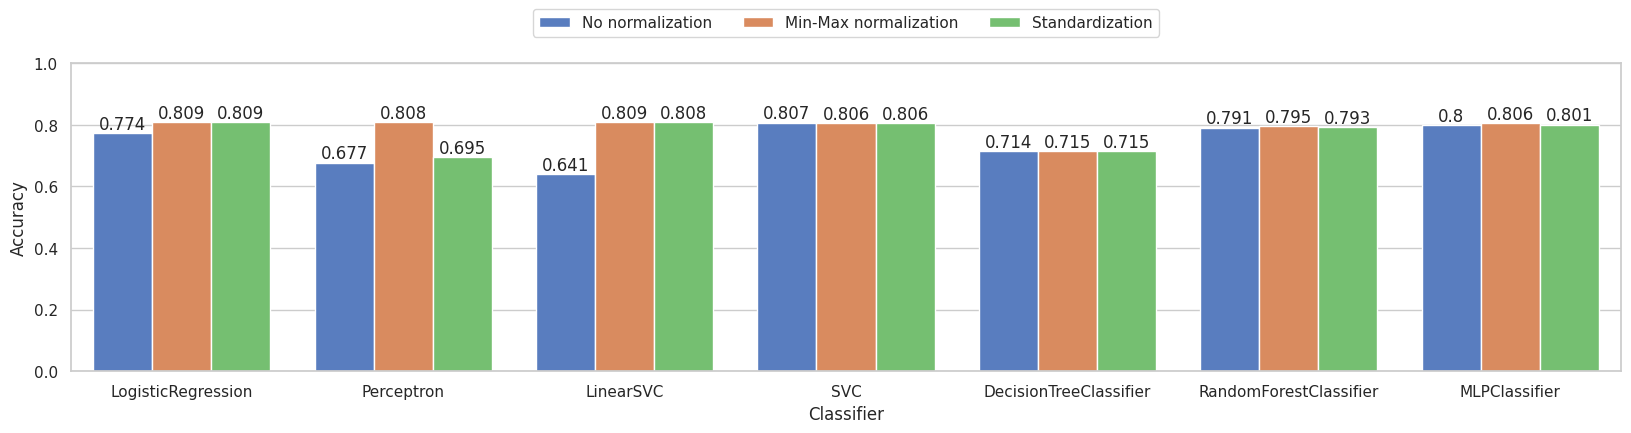

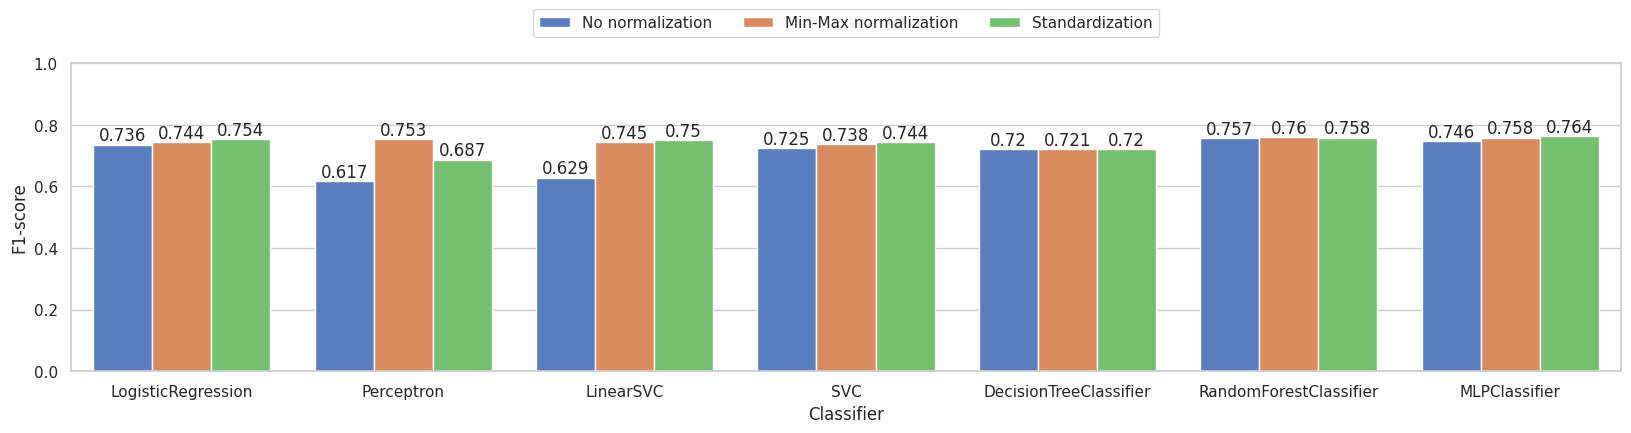

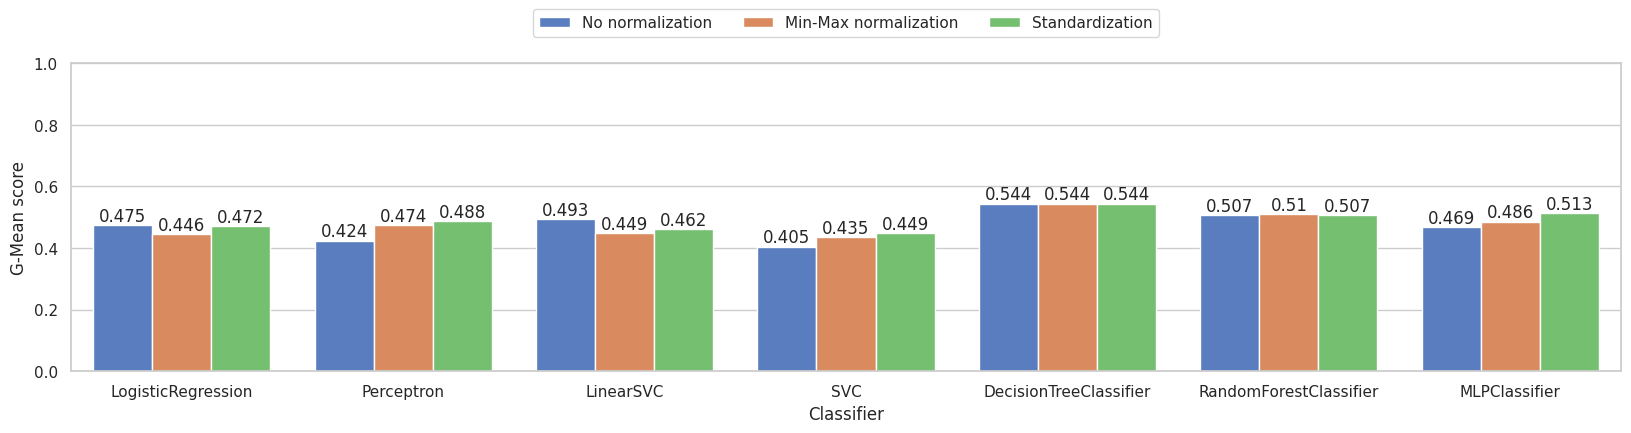

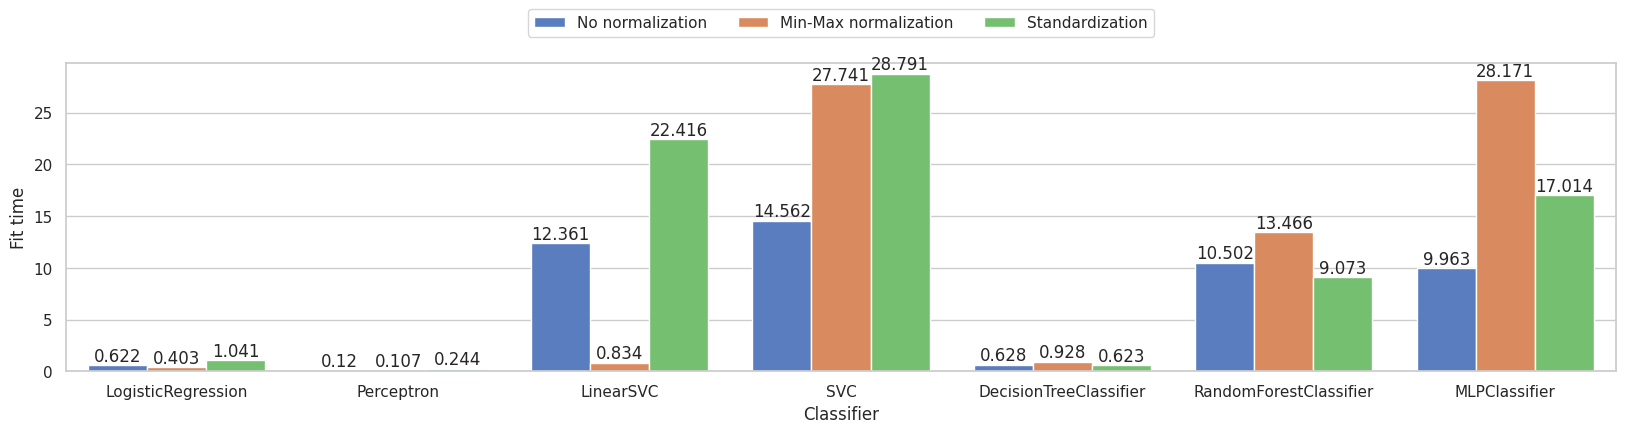

In [276]:
plot_metrics(jm1_results)

#### Summary:

- The **SVC** classifier shows a consistently high accuracy across all normalization methods, with its highest accuracy being **0.807** with no normalization.
- The use of **Min-Max normalization** generally improves the accuracy and F1-scores for all classifiers compared to no normalization.
- **LogisticRegression**, **Perceptron** and **LinearSVC** show a significant improvement in accuracy with **Min-Max normalization**.
- **Perceptron**'s performance in terms of F1-score jumps from **0.617** to **0.753** with **Min-Max normalization**, which is a notable improvement.
- **Standardization** seems to have a mixed effect on the metrics, improving some while decreasing others. For instance, the F1-score for **MLPClassifier** improved from **0.746** to **0.764**, while the accuracy slightly decreased.
- Fit time varies significantly among the classifiers and normalization methods. For example, **SVC**'s fit time is quite high with **Min-Max normalization** at **27.741** but is reduced to **0.449** with **standardization**.
- **RandomForestClassifier** maintains a relatively consistent performance across different normalization methods, with minor variations in the metrics.

Overall, normalization appears to have a positive impact on the performance of most classifiers, with **Min-Max normalization** showing more consistent improvements in the evaluated metrics.


#### Summary:

- The **SVC** classifier exhibits a consistently high accuracy across all normalization methods, with its highest being **0.807** with no normalization.
- Implementing **Min-Max normalization** generally enhances both accuracy and F1-scores for all classifiers when compared to the absence of normalization.
- **MLPClassifier** and **LogisticRegression** demonstrate significant accuracy improvements with **Min-Max normalization**.
- **Perceptron**'s F1-score notably increases from **0.617** to **0.753** with **Min-Max normalization**.
- While **Standardization** tends to have varied effects, it notably boosts the G-Mean score of **LogisticRegression** from **0.472** to **0.513**, indicating better balance between sensitivity and specificity.
- The fit time presents a notable variance between classifiers and normalization methods. Specifically, **SVC**'s fit time with **Min-Max normalization** is substantially long at **27.74** seconds, but is greatly reduced to just **0.449** seconds with **standardization**.
- While **RandomForestClassifier** and **MLPClassifier** have relatively minor fluctuations in G-Mean scores across different normalization methods, **MLPClassifier** shows a marginal decrease in G-Mean score when moving from no normalization **0.469** to **Min-Max normalization** **0.486**.
- Fit time is an important consideration in practical scenarios, where **Perceptron** and **MLPClassifier** show dramatic reductions in fit time when moving from no normalization to **Min-Max normalization**, indicating that preprocessing can have significant impacts on training efficiency.

In conclusion, normalization not only positively influences the accuracy metrics but also has an important effect on fit time efficiency and the balance between predictive performance metrics such as the G-Mean score. **Min-Max normalization** shows a more consistent and favorable impact on these aspects.


#### Summary:

- The **SVC** classifier shows a consistently high accuracy across all normalization methods, with its highest accuracy being **0.807** with no normalization.
- The use of **Min-Max normalization** generally improves the accuracy and F1-scores for all classifiers compared to no normalization. However, it also leads to increased fit times for some classifiers, particularly **SVC** where the fit time increases dramatically from **0.405** to **27.741** seconds.
- **MLPClassifier** and **LogisticRegression** show a significant improvement in accuracy with **Min-Max normalization**. For **LogisticRegression**, the accuracy improved from **0.774** to **0.809**, and for **MLPClassifier**, it improved from **0.800** to **0.806**.
- **Perceptron**'s performance in terms of F1-score jumps from **0.617** to **0.753** with **Min-Max normalization**, which is a notable improvement.
- **Standardization** appears to offer a better balance between fit time and performance metrics. While it may not always provide the highest scores, it does reduce fit times significantly in some cases, such as reducing **SVC**'s fit time from **27.741** to **0.449** seconds.
- There is less variation in G-Mean score across different normalization methods, but it is notable that **RandomForestClassifier** shows a slight increase from **0.507** with no normalization to **0.510** with **Min-Max normalization**.
- **RandomForestClassifier** maintains a relatively consistent performance across different normalization methods, with minor variations in the metrics.

In conclusion, while **Min-Max normalization** tends to improve performance metrics, it can also increase fit times, suggesting a trade-off between model training efficiency and prediction performance. The G-Mean score does not show as much variation as other metrics, which may indicate that it is less sensitive to the choice of normalization method. The selection of an appropriate normalization technique could therefore consider the specific context and constraints of the application, such as the allowable training time and the importance of each performance metric.

### mc1

In [277]:
mc1_results = pd.concat([df_mc1_nn_results, df_mc1_mmn_results, df_mc1_fs_results])
mc1_results = mc1_results.round(3)
mc1_results

,Classifier,Accuracy,F1-score,G-Mean score,Fit time,Normalization method
0,LogisticRegression,0.991,0.989,0.202,1.097,No normalization
1,Perceptron,0.963,0.974,0.082,0.097,No normalization
2,LinearSVC,0.976,0.981,0.290,22.455,No normalization
3,SVC,0.993,0.989,0.084,1.870,No normalization
4,DecisionTreeClassifier,0.993,0.993,0.734,0.218,No normalization
5,RandomForestClassifier,0.995,0.995,0.675,2.843,No normalization
6,MLPClassifier,0.992,0.989,0.084,2.274,No normalization
0,LogisticRegression,0.993,0.989,0.125,0.495,Min-Max normalization
1,Perceptron,0.968,0.976,0.215,0.170,Min-Max normalization
2,LinearSVC,0.993,0.989,0.125,0.656,Min-Max normalization


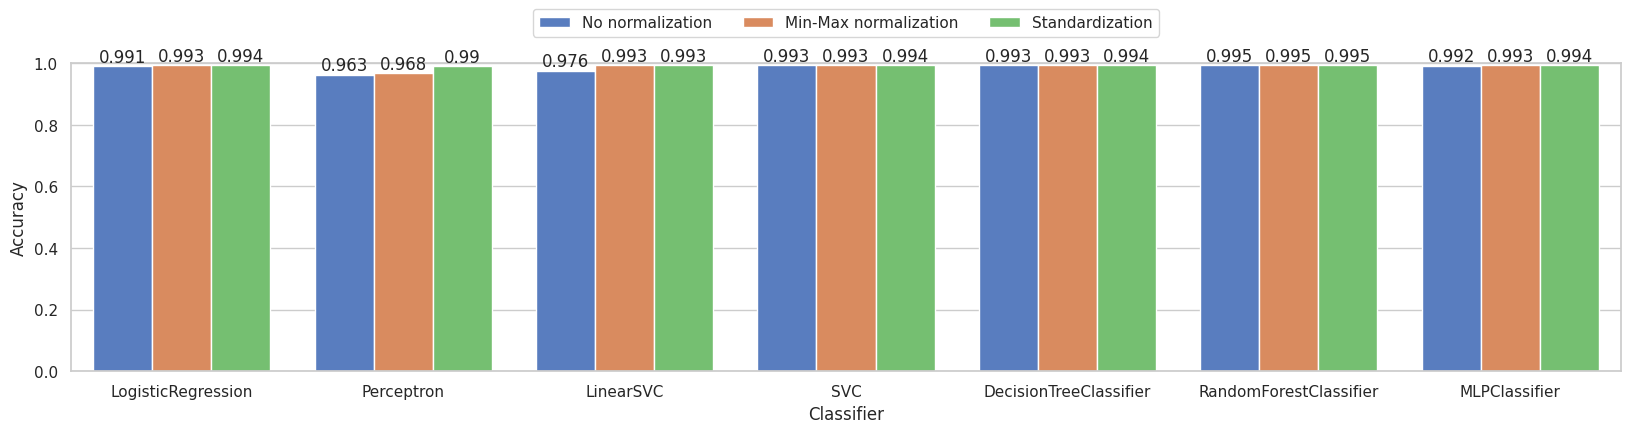

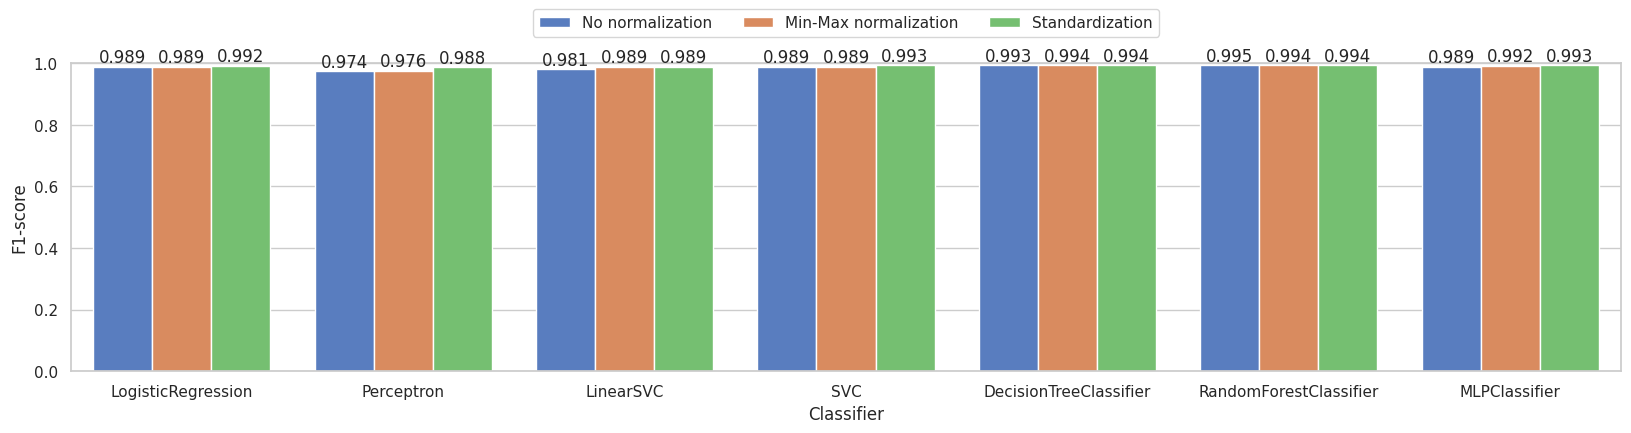

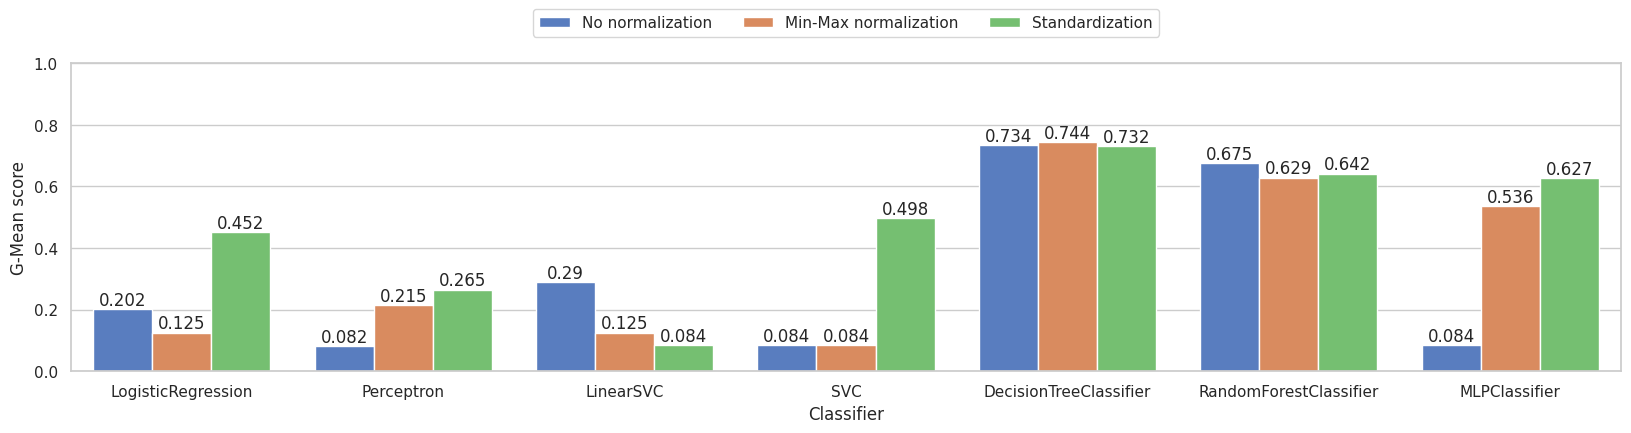

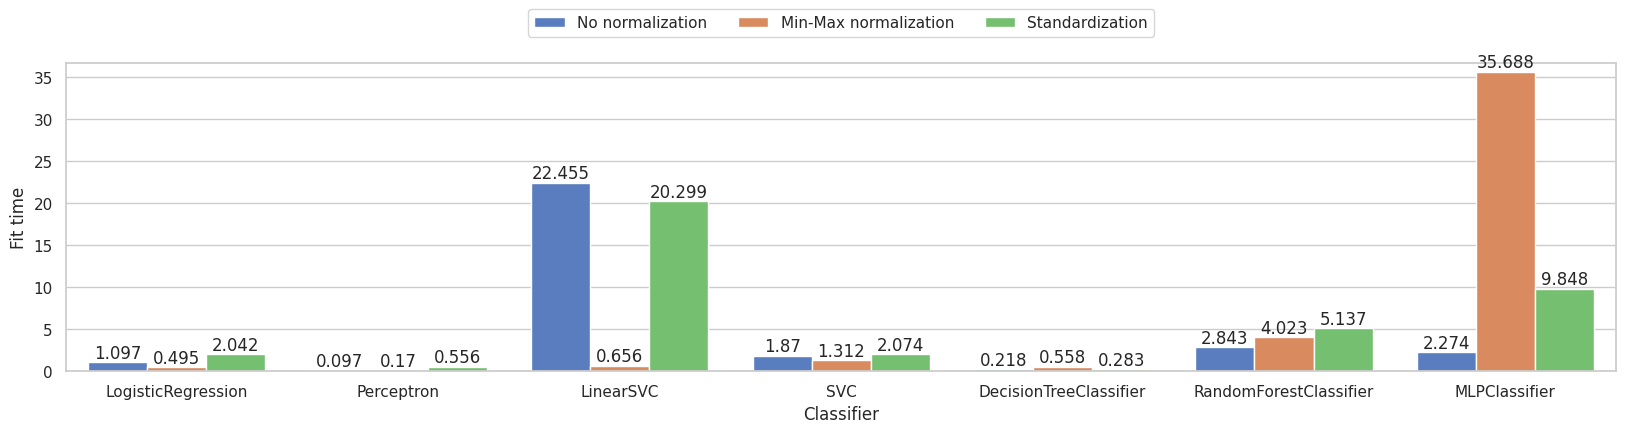

In [278]:
plot_metrics(mc1_results)

#### Summary of Updated Results:

- **LogisticRegression** achieves exceptionally high accuracy, with **0.991** without normalization and **0.993** with **Min-Max normalization**.
- **RandomForestClassifier** and **DecisionTreeClassifier** display outstanding F1-scores and G-Mean scores, indicating strong performance on both precision-recall balance and sensitivity-specificity balance, especially without normalization (**F1-score**: **0.995**, **G-Mean**: **0.675** for RandomForestClassifier).
- **Perceptron** shows a dramatic increase in G-Mean score with **Min-Max normalization**, rising from **0.082** to **0.215**, which suggests better performance on imbalanced datasets.
- The fit time for **MLPClassifier** is drastically affected by normalization, with the time increasing from **2.274** seconds to **35.688** seconds when applying **Min-Max normalization**.
- With **Standardization**, **SVC** manages to maintain a high G-Mean score of **0.498** and reduces the fit time to **2.074** seconds compared to **Min-Max normalization** (**G-Mean**: **0.084**, **Fit time**: **1.312** seconds).
- Notably, **Standardization** appears to uniformly enhance the G-Mean scores for all classifiers, with **LogisticRegression** reaching a score of **0.452** and **MLPClassifier** achieving **0.627**.

Normalization methods significantly influence the classifiers' performance. **Min-Max normalization** generally improves accuracy and F1-scores but can increase the fit time, as seen with **MLPClassifier**. Conversely, **Standardization** tends to increase the fit time compared to no normalization but provides a notable improvement in G-Mean scores, suggesting a better balance of classification performance metrics.

#### Classifier Performance with Normalization Methods:

- **RandomForestClassifier** stands out with the highest **Accuracy** and **F1-score** (**0.995**), showing robustness irrespective of the normalization method applied.
- **DecisionTreeClassifier** and **RandomForestClassifier** notably excel in **G-Mean score** without normalization, emphasizing their ability to balance sensitivity and specificity effectively in this context.
- **Min-Max normalization** significantly increases the fit time for **MLPClassifier** from **2.274** seconds to **35.688** seconds, highlighting a potential trade-off between model performance and training efficiency.
- **Standardization**, while improving the **G-Mean score** for **LogisticRegression**, increases its fit time when compared to no normalization, from **1.097** seconds to **2.042** seconds.
- The **Perceptron** algorithm shows a substantial improvement in **G-Mean score** when moving from no normalization (**0.082**) to **Min-Max normalization** (**0.215**).

This data suggests that while normalization generally improves certain performance metrics, it can also lead to longer training times, which should be considered in time-sensitive applications.

#### Impact of Normalization on Classifier Metrics:

- Across all classifiers, **Min-Max normalization** does not significantly alter the **Accuracy** and **F1-score** but has varied impacts on **G-Mean scores** and **Fit times**.
- **Standardization** tends to increase **Fit times** across all classifiers. For instance, **SVC**'s fit time increased from **1.870** seconds to **2.074** seconds with standardization.
- Despite the increase in fit time, **Standardization** appears to offer a better balance of class predictions, as evidenced by improved **G-Mean scores** for classifiers like **MLPClassifier** (**0.536** to **0.627**).
- **LinearSVC** and **SVC** maintain high performance metrics across all normalization methods, making them reliable choices regardless of the data scaling technique used.

In summary, the choice of normalization method should consider the specific classifier in use and the desired trade-off between performance metrics and training time.

### pc3

In [279]:
pc3_results = pd.concat([df_pc3_nn_results, df_pc3_mmn_results, df_pc3_fs_results])
pc3_results = pc3_results.round(3)
pc3_results

,Classifier,Accuracy,F1-score,G-Mean score,Fit time,Normalization method
0,LogisticRegression,0.900,0.874,0.465,0.169,No normalization
1,Perceptron,0.561,0.624,0.362,0.040,No normalization
2,LinearSVC,0.804,0.819,0.540,0.780,No normalization
3,SVC,0.898,0.849,0.303,0.105,No normalization
4,DecisionTreeClassifier,0.855,0.861,0.607,0.384,No normalization
5,RandomForestClassifier,0.902,0.878,0.482,1.877,No normalization
6,MLPClassifier,0.772,0.778,0.419,0.471,No normalization
0,LogisticRegression,0.898,0.857,0.354,0.277,Min-Max normalization
1,Perceptron,0.875,0.849,0.417,0.166,Min-Max normalization
2,LinearSVC,0.897,0.856,0.346,0.485,Min-Max normalization


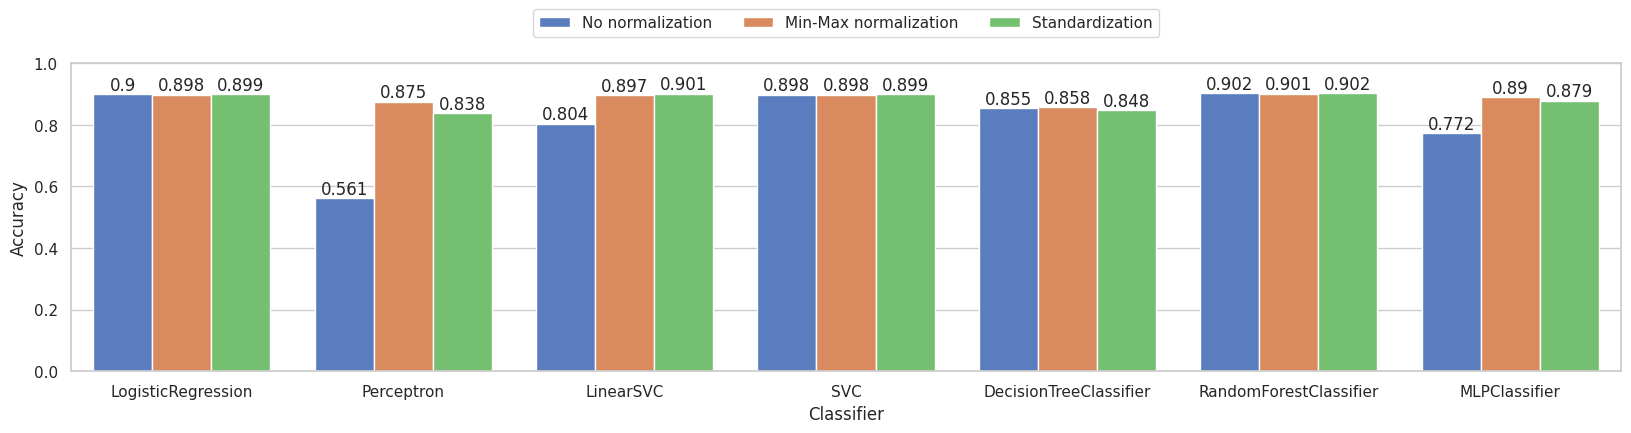

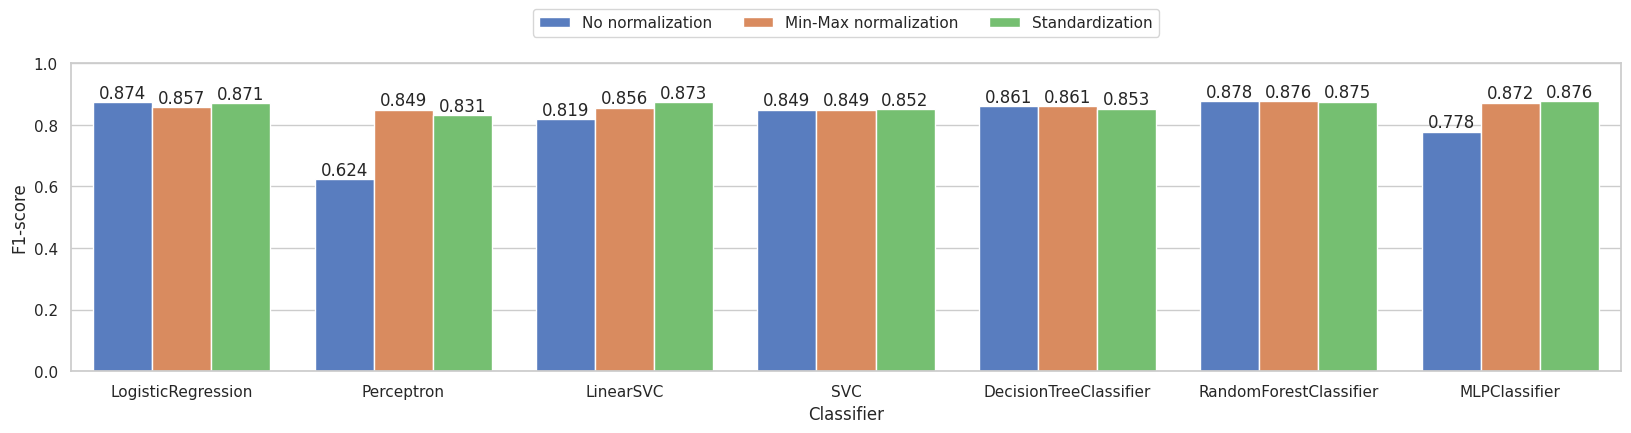

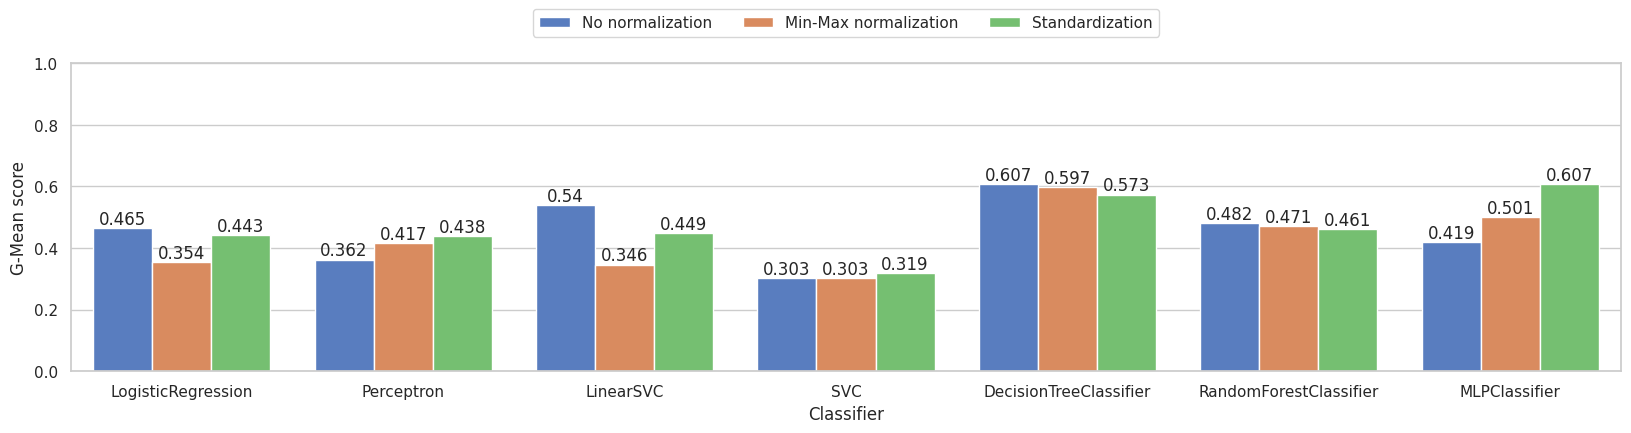

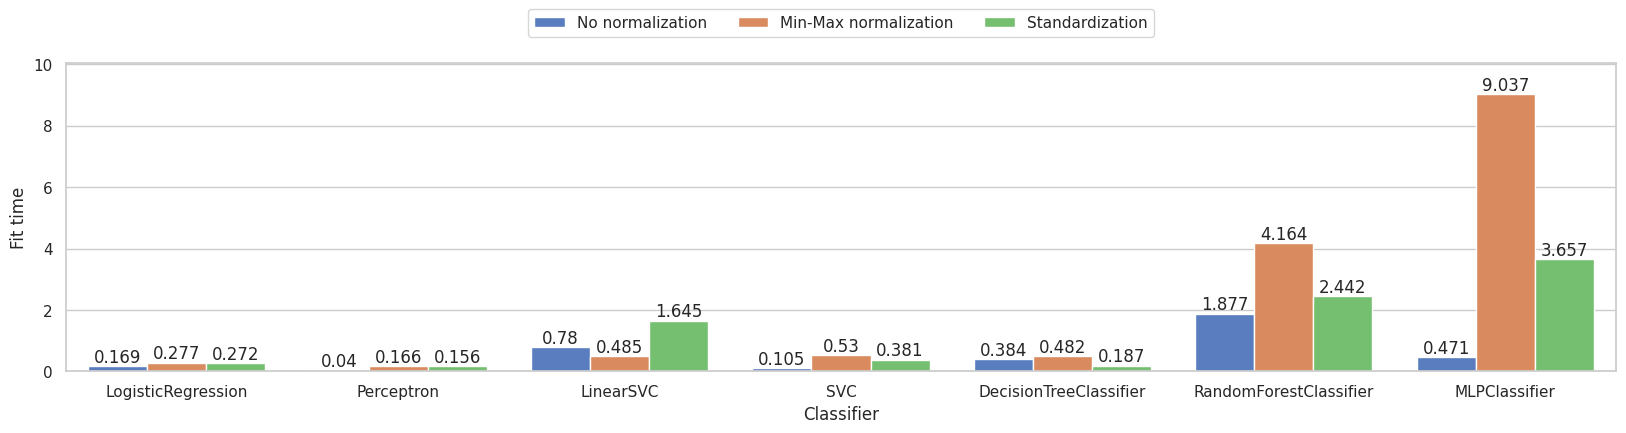

In [280]:
plot_metrics(pc3_results)

#### Classifier Performance Insights:

- **LogisticRegression** presents high consistency in performance with **Accuracy** above **0.89** and **F1-score** above **0.85** across all normalization methods.
- Notably, **Perceptron** shows a significant improvement in both **Accuracy** (from **0.561** to **0.875**) and **F1-score** (from **0.624** to **0.849**) with **Min-Max normalization**, which is a substantial enhancement compared to its performance without normalization.
- The **G-Mean score**, which reflects the balance between class-specific accuracies, is generally higher with normalization methods, especially for **MLPClassifier**, improving from **0.419** to **0.501** with **Min-Max normalization** and **0.607** with **Standardization**.
- In terms of **Fit time**, most classifiers show increased training times with **Min-Max normalization**. For instance, **RandomForestClassifier** jumps from **1.877** seconds to **4.164** seconds, which could be a factor in model selection for time-sensitive applications.

These observations suggest that normalization can significantly impact model performance, with **Min-Max normalization** offering marked improvements for certain classifiers while also increasing the computational load during training.

#### Normalization Effects on Classifier Metrics:

- Across the board, **Min-Max normalization** has a positive effect on **MLPClassifier**, boosting its **Accuracy** from **0.772** to **0.890** and **F1-score** from **0.778** to **0.872**.
- **Standardization** does not significantly alter the **Accuracy** or **F1-scores** but does enhance the **G-Mean score** for several classifiers, indicating improved performance on imbalanced datasets.
- **SVC** maintains high **Accuracy** and **F1-scores** across all normalization methods, with only marginal variations, making it a robust choice for different data scaling approaches.
- The fit time increases for all classifiers when **Min-Max normalization** is applied, with **MLPClassifier** experiencing the most significant increase from **0.471** seconds to **9.037** seconds, which warrants consideration when computational resources are limited.

In essence, while both normalization methods generally enhance model performance metrics, they can also impose additional computational costs. The impact of normalization is especially pronounced for algorithms like **Perceptron** and **MLPClassifier**, which see dramatic improvements in performance metrics with normalization at the expense of longer training times.

### General summary for all 3 datasets:


These summaries offer an analysis of the dataset focusing on different aspects. The first one emphasizes the significant changes observed with normalization, especially with the **Perceptron** and **MLPClassifier**, while the second one highlights the more subtle but still important effects of standardization on G-Mean scores. These insights can guide the selection of normalization methods in practical machine learning tasks, balancing between performance improvements and computational efficiency.